# Time Series Forecasting

### Author: @shubhnk (Shubhank Bhandarkar)

In [1]:
# Installing and loading libraries
list.of.packages <- c('data.table','lubridate','forecast','smooth','forecastHybrid','QuantTools','TTR','randomForest',
                      'prophet','tidyverse','tseries','Metrics')
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])];
if(length(new.packages)) install.packages(new.packages, repos = "http://cran.us.r-project.org");
for (lib in list.of.packages) suppressWarnings(suppressMessages(library(lib,character.only = TRUE)))
set.seed(123) # Setting seed to make the ouputs reproducable 
options(repr.plot.width = 16)

## Time Series terminology and overview

Time series data is a collection of quantities that are assembled over even intervals in time and ordered chronologically.  
The best way to find the characteristics of timeseries, is to plot them and try to find below questions -  
1. Does it have a time trend?
2. Does it exhibit seasonality or cyclicity (repetivitve patterns over fixed time)
3. Does it demonstrate structural breaks?  

There are two main ways to decompose the timeseries - Additive or Multiplicative model.   
**Additive**:   
Y = Trend + Seasonal + Random  
**Multiplicative**:  
Y = Trend x Seasonal x Random  

**Why do we need to decompose the series?**  
In statistics, timeseries forecasting can only be done on stationary series. A stationary time series is one whose properties do not depend on the time. In short, the series should be random and should not have trend or seasonality. Thus, we have to detrend and deseasonalize the timeseries before starting timeseries forecasting.  

**How to check if the timeseries is stationary?**  
Normally this can done though visualization of random component. This random component should not show any trend or seasonality. But if you wish to check this statistically, we can use ACF and PACF plots to see if there are any corelation with the previous lag terms. There are also tests like Augmented Dickey-Fuller Test (adf test) and Ljung-Box test. 

Now-a-days most of the timeseries packages have built-in methods to do this but we will show this with small use case.

## Data Overview and Exploration

In this tutorial, we will use two standard datasets, AirPassengers (from base R) and gas (from forecast package). Both the dataset is in timeseries format by default so we can directly plot them   
For AirPassengers data, we can clearly observe that the timeseries in increasing overtime and the pattern is repeating after some interval (here 12 months).This will be our primary dataset for most of the analysis  
In gas data, the timeseries is flat for some time and then the growth exploded. This too have repetitive pattern

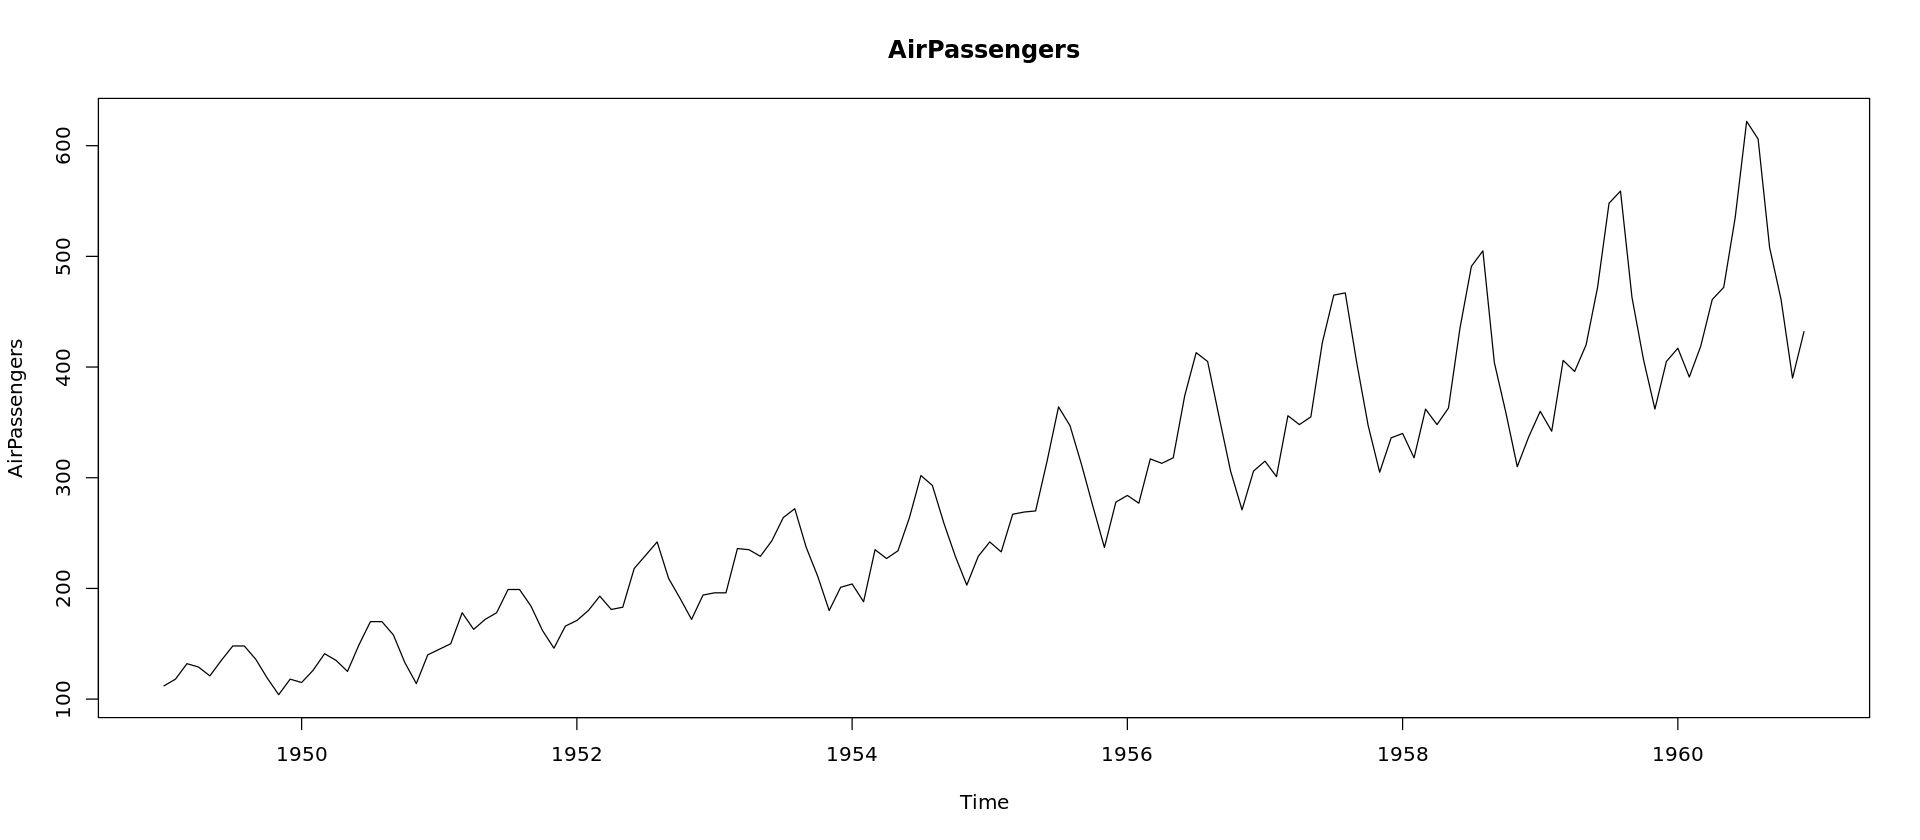

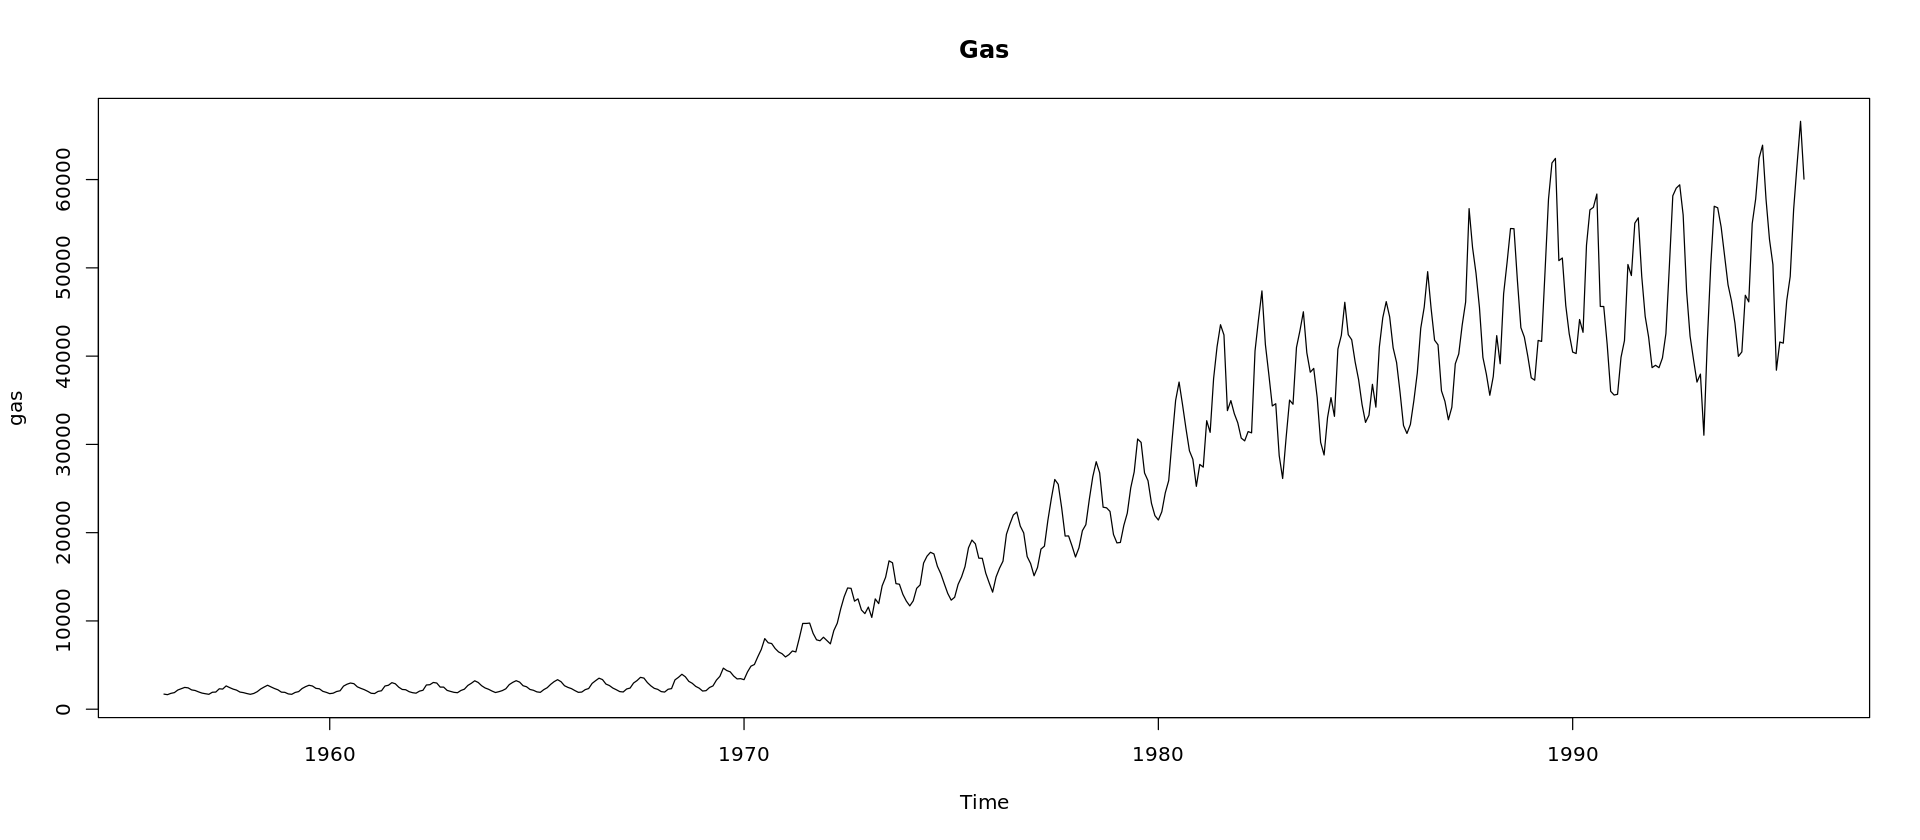

In [2]:
plot(AirPassengers,main='AirPassengers')
plot(gas, main='Gas')

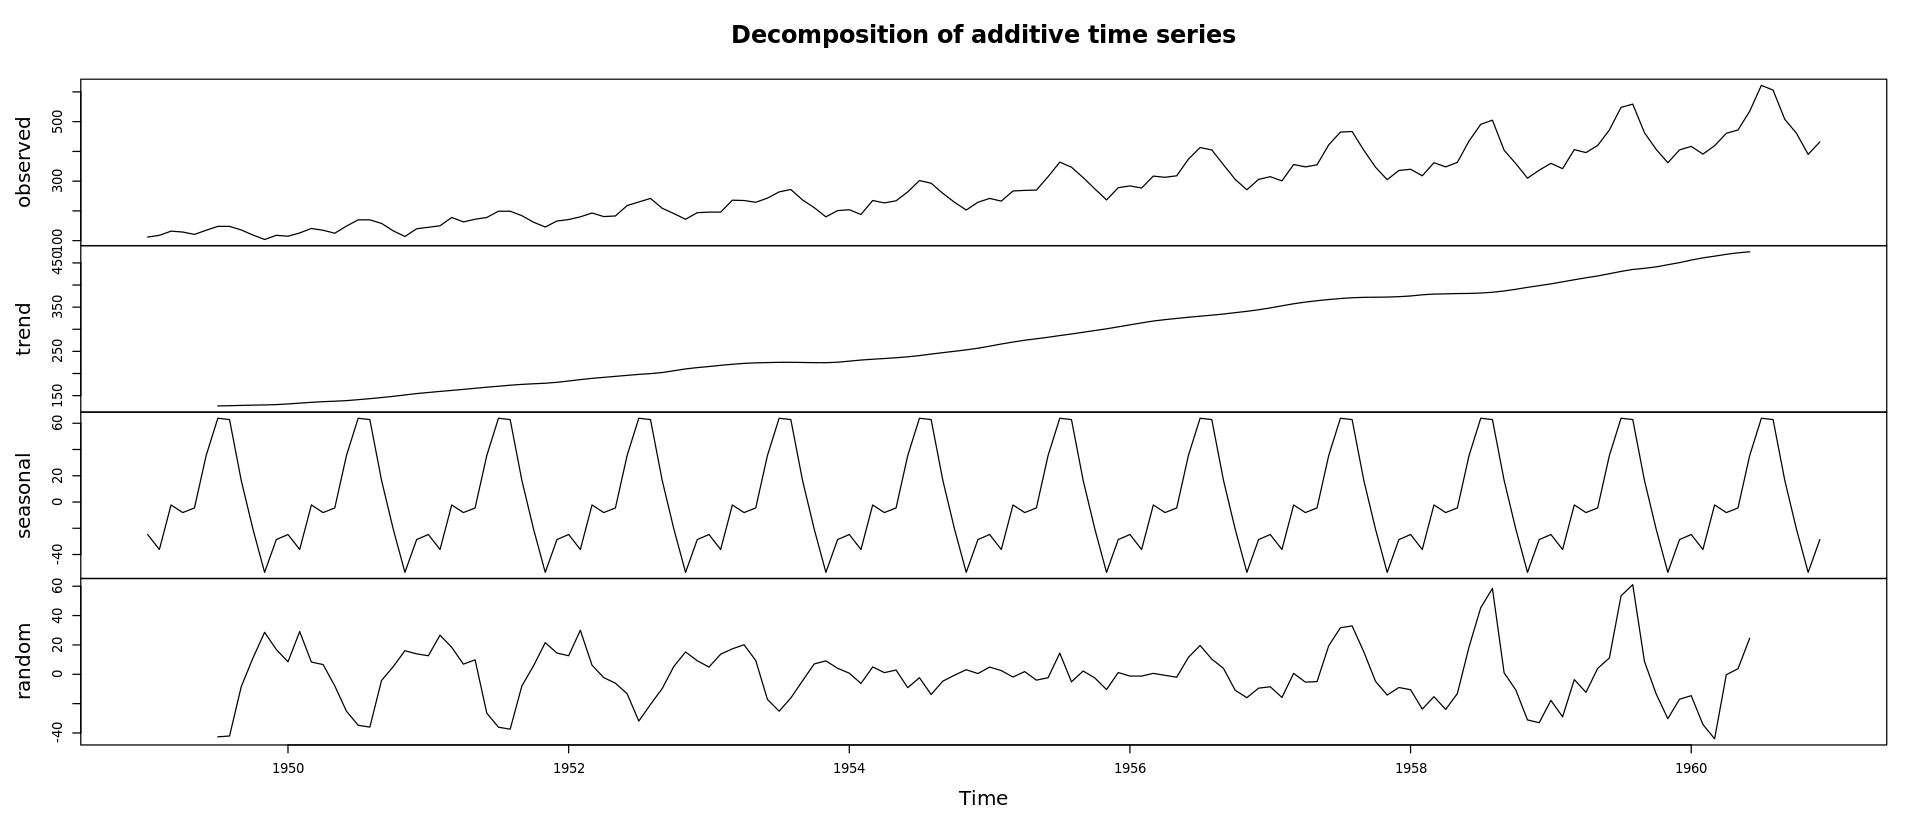

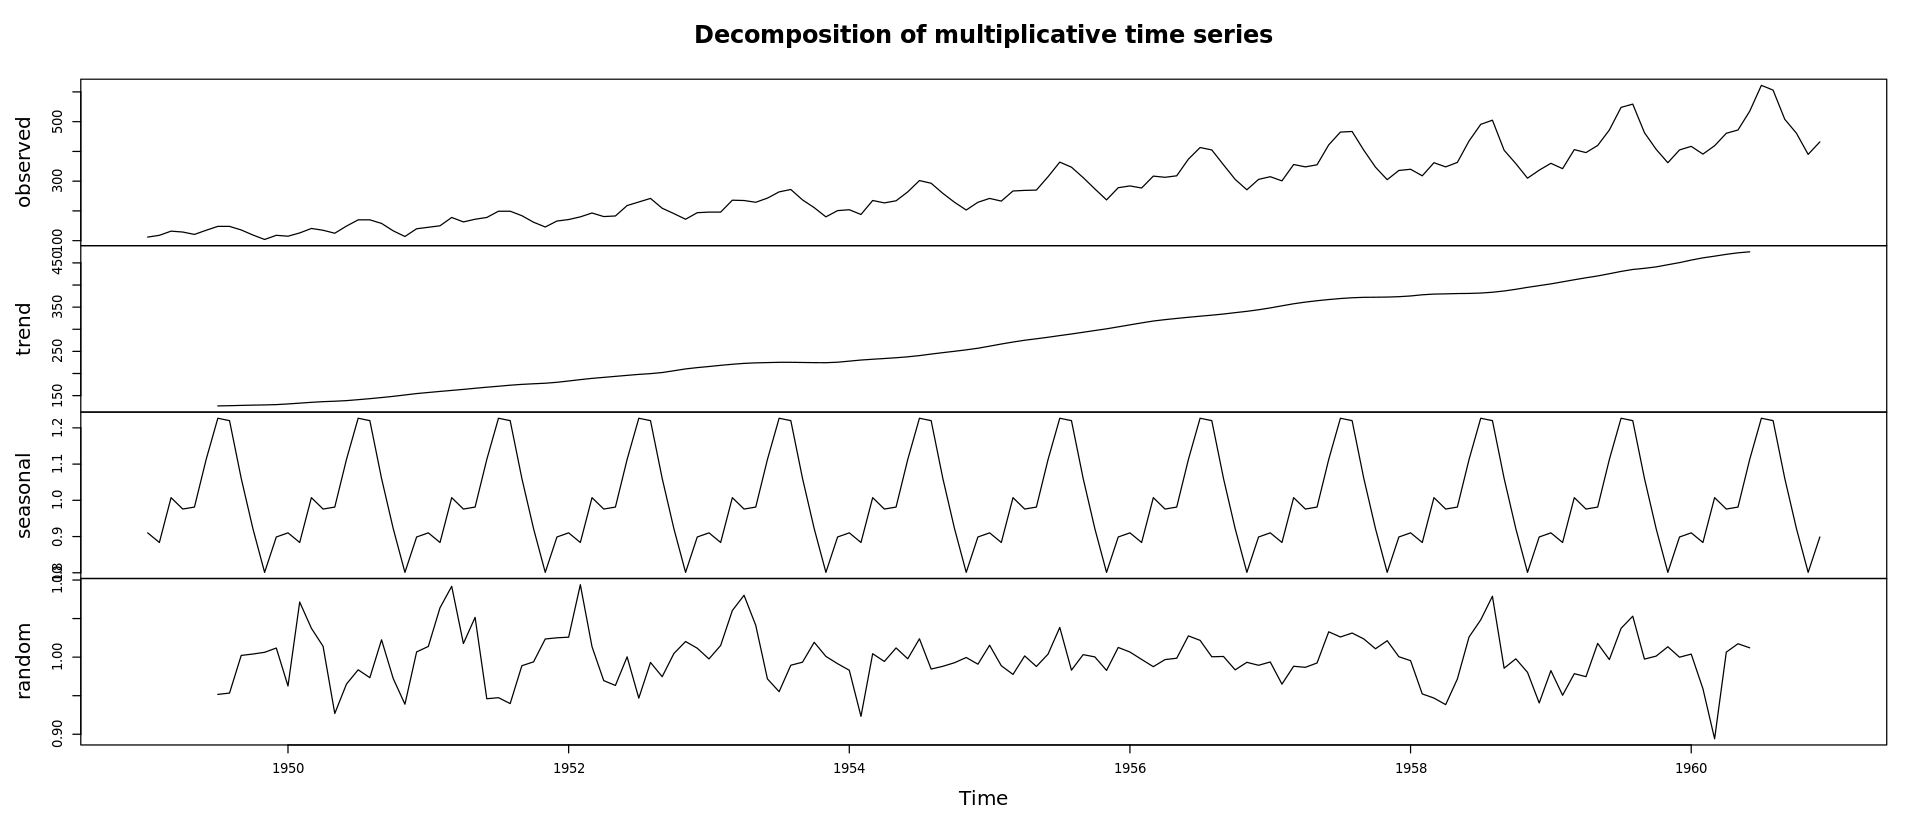

In [3]:
plot(decompose(AirPassengers,type='additive'))
plot(decompose(AirPassengers,type='multiplicative'))

**What are the different ways to extract trend and seasonality?**  
We can use the built-in packages/functions such as decompose or stl. If you wish to manually compute this, you will have to first compute trend, the detrend the series. Compute seasonality of the detrended series to get deseasonalized series. You will be left with random component. On plotting if you still see some trend/seasonality then the detrend/deseasonal methods were in-correct and try different methods.  
It is very crucial to understand the trend and seasonal components of the timeseries, else we can end up with incorrect forecasts.  
**Trend Computation**: Crude and universal method to extract trend is to get the difference from the previous value. Other method is moving average where the window of lag is the seasonality period. If the increase/decrease is non-linear then you can apply Box-Cox transformations such as log, exponentials to dampen or explode some part of the series and make it linear.  
**Seasonality Computation**: General method for this is to take an average over the lagged seasonal periods. For example, in monthly data, compute average of Jan over past years would give seasonality component for Jan. Make sure you pass detrended output as the raw data.  

For simplicity we will use STL package to decomponse the series

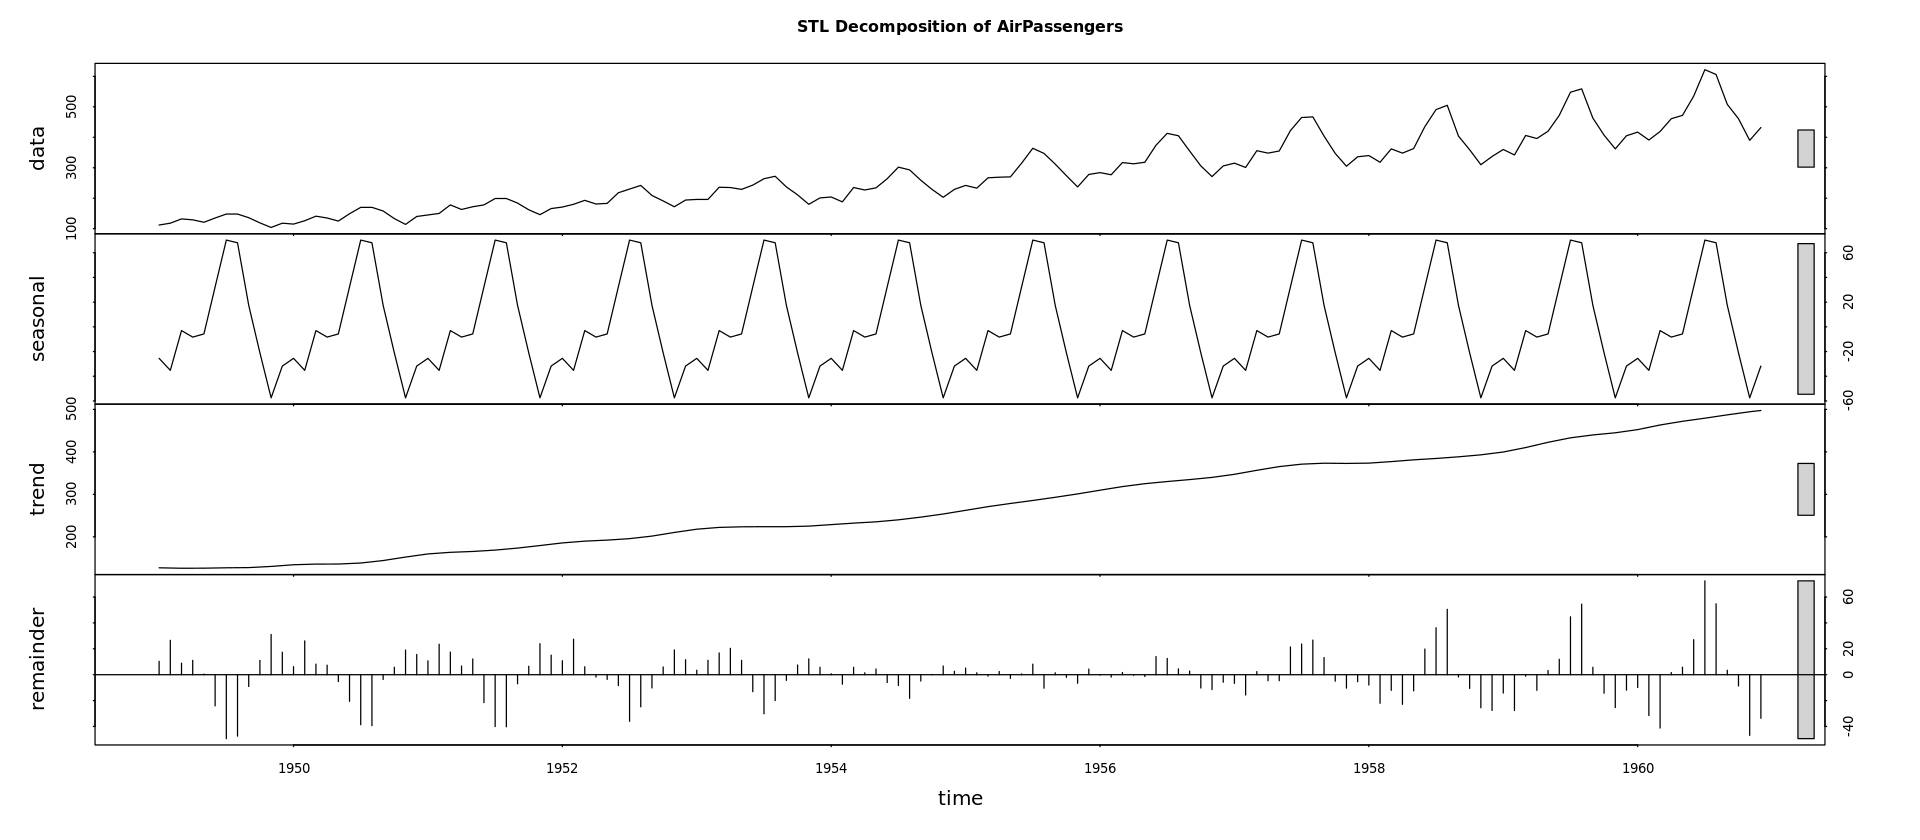

In [4]:
plot(stl(AirPassengers,s.window='periodic'),main='STL Decomposition of AirPassengers')

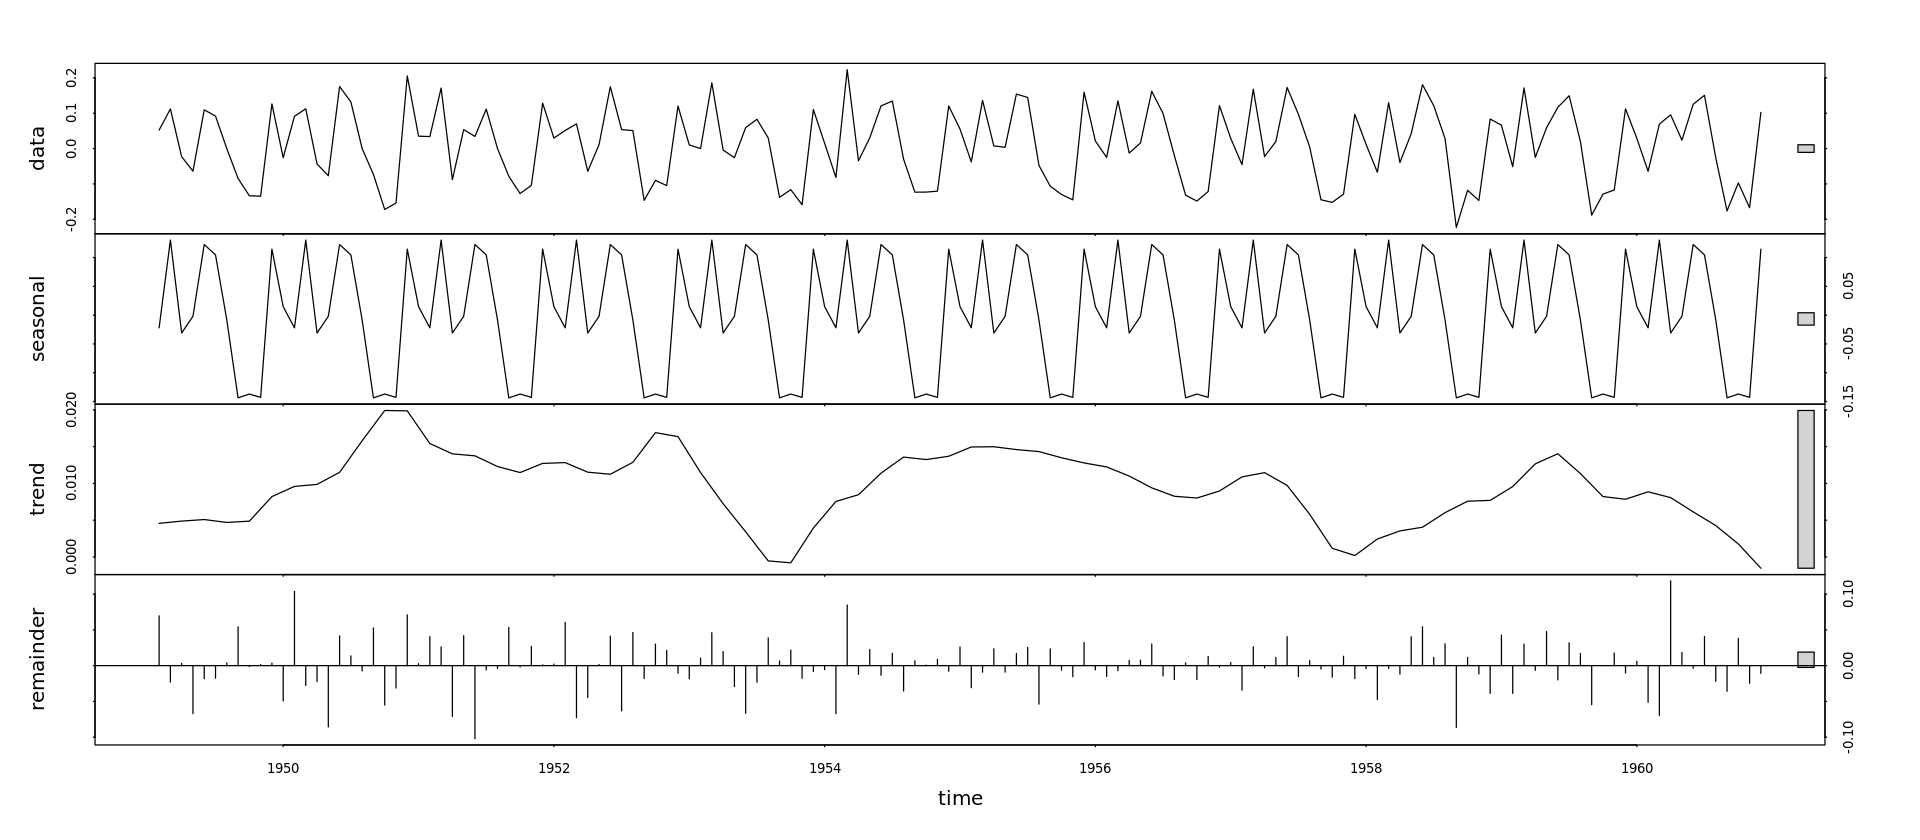

In [5]:
plot(stl(diff(log(AirPassengers)),s.window='periodic'))

In [6]:
detrnd_airpass <- diff(log(AirPassengers))
stl_airpass <- stl(diff(log(AirPassengers)),s.window='periodic')
stl_airpass_rnd <- stl_airpass$time.series[,3]

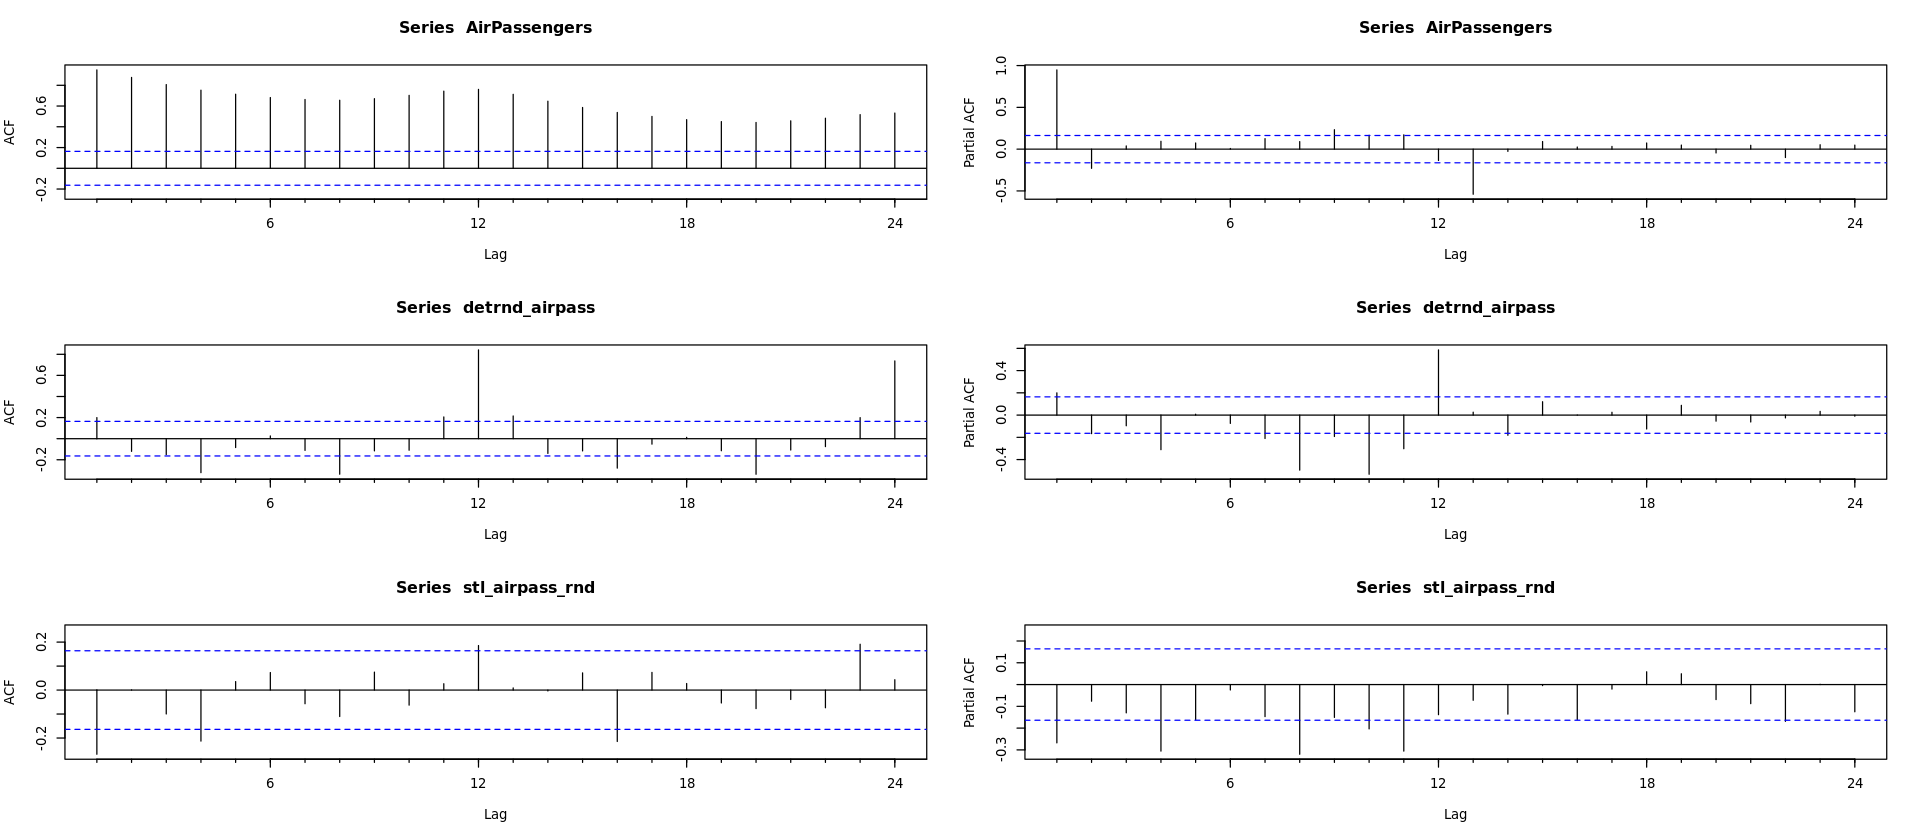

In [7]:
par(mfrow=c(3,2))
Acf(AirPassengers)
Pacf(AirPassengers)
Acf(detrnd_airpass)
Pacf(detrnd_airpass)
Acf(stl_airpass_rnd)
Pacf(stl_airpass_rnd)

## Forecasting Methods

### Seasonal Naive for baseline forecasts

snaive() returns forecasts and prediction intervals from an ARIMA(0,0,0)(0,1,0)m model where m is the seasonal period.

In [8]:
tsAir_trn <- head(AirPassengers,length(AirPassengers)-12)
tsAir_val <- tail(AirPassengers,12)
dt_airpass_nv <- data.table(ds=seq.Date(from=as.Date('1949-01-01'), to=as.Date('1960-12-01'), 'months'), 
                            y=as.numeric(AirPassengers))
dt_airpass_nv[,':='(yhat=as.numeric(NA),yhatlog=as.numeric(NA))]

mnv <- snaive(tsAir_trn,h=12)
mnvlog <- snaive(log(tsAir_trn),h=12)

dt_airpass_nv[ds>='1960-01-01'
              ,':='(yhat=as.numeric(predict(mnv,12)$mean),
                    yhatlog=as.numeric(exp(predict(mnvlog,12)$mean)))]
mape_air_nv <- mape(dt_airpass_nv[ds>='1960-01-01']$y, dt_airpass_nv[ds>='1960-01-01']$yhat)
mape_air_nvlog <- mape(dt_airpass_nv[ds>='1960-01-01']$y, dt_airpass_nv[ds>='1960-01-01']$yhatlog)
cat(sprintf('SNAIVE MAPE without log is %s\n',round(mape_air_nv,5)))
cat(sprintf('SNAIVE MAPE with log is %s\n',round(mape_air_nvlog,5)))

SNAIVE MAPE without log is 0.09988
SNAIVE MAPE with log is 0.09988


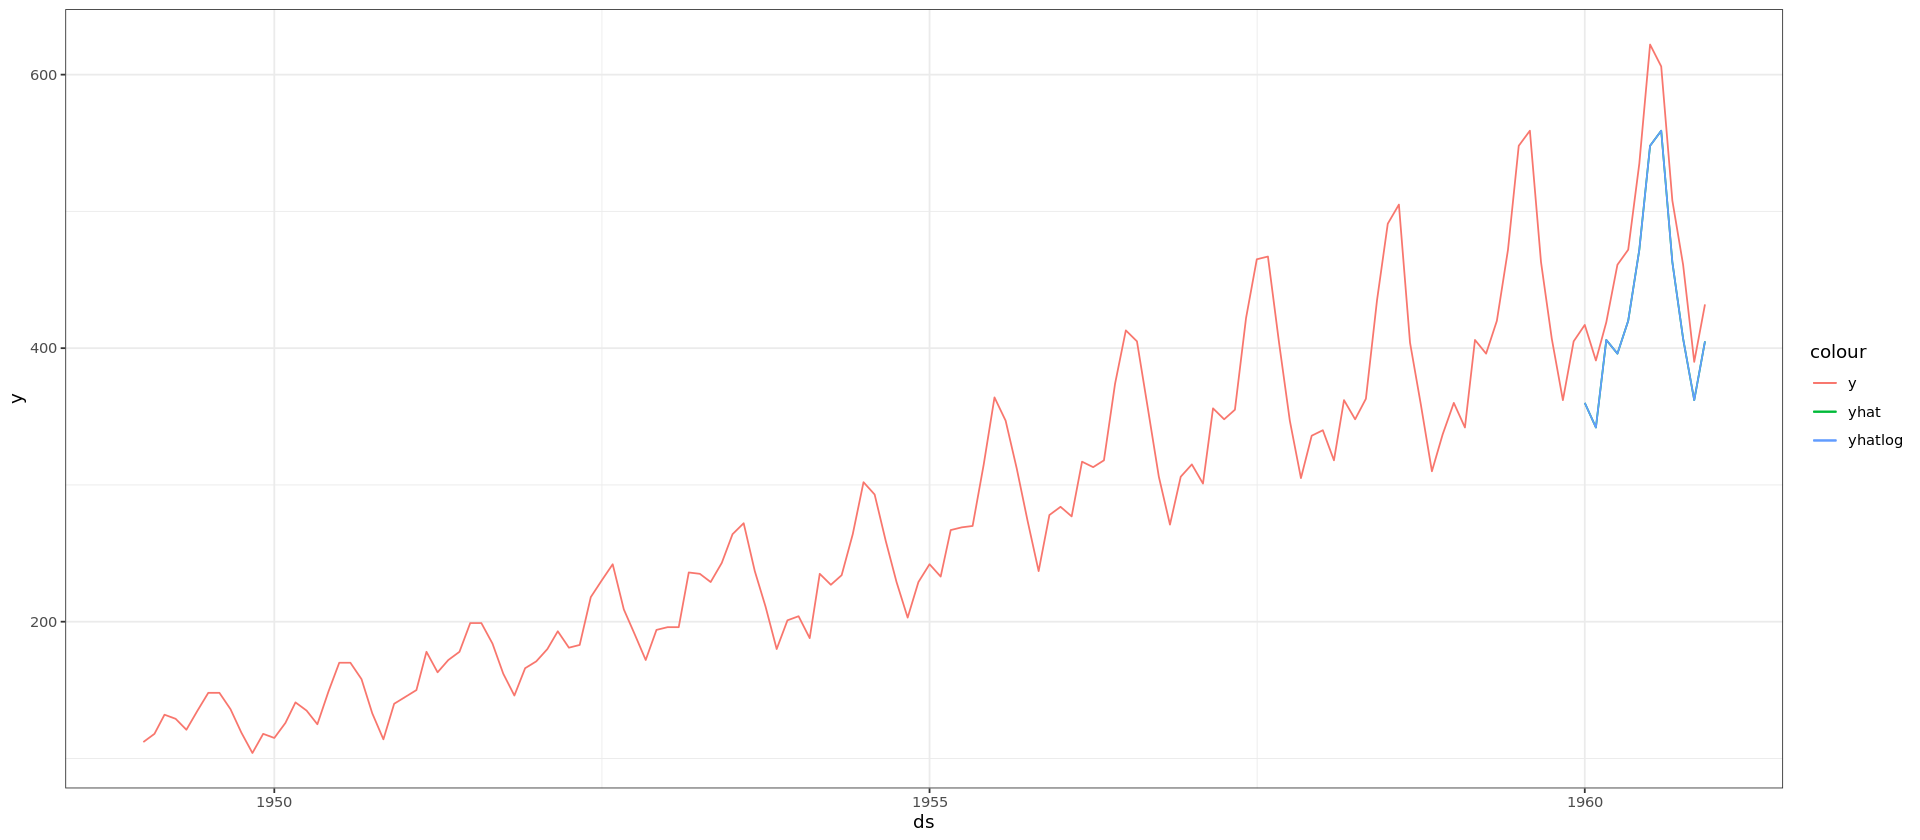

In [9]:
ggplot(dt_airpass_nv, aes(x=ds)) +
    geom_line(aes(y=y, color='y'), na.rm=TRUE) + 
    geom_line(aes(y=yhat, color='yhat'), na.rm=TRUE) + 
    geom_line(aes(y=yhatlog, color='yhatlog'), na.rm=TRUE) + theme_bw()

### ARIMA

ARIMA models contain three things:
1. **AR(p)**: autoregressive part of the model. Means that we use p past observations from the timeseries as predictors.
2. **Differencing (d)**: Used to transform the timeseries into a stationary one by taking the differences between successive observations at appropriate lags d.
3. **MA(q)**: uses q past forecast errors as predictors.
That’s it for ARIMA but if you know the data you have is seasonal, then you need more. That’s where SARIMA comes into play.  
SARIMA adds a seasonal part to the model.

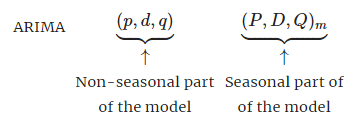

In [10]:
tsAir_trn <- head(AirPassengers,length(AirPassengers)-12)
tsAir_val <- tail(AirPassengers,12)
dt_airpass_ar <- data.table(ds=seq.Date(from=as.Date('1949-01-01'), to=as.Date('1960-12-01'), 'months'), 
                            y=as.numeric(AirPassengers))
dt_airpass_ar[,':='(yhat=as.numeric(NA),yhatlog=as.numeric(NA))]

In [11]:
mARIMA <- auto.arima(tsAir_trn)
mARIMA

Series: tsAir_trn 
ARIMA(1,1,0)(0,1,0)[12] 

Coefficients:
          ar1
      -0.2431
s.e.   0.0894

sigma^2 = 109.8:  log likelihood = -447.95
AIC=899.9   AICc=900.01   BIC=905.46

In [12]:
mARIMAlog <- auto.arima(log(tsAir_trn))
mARIMAlog

Series: log(tsAir_trn) 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.3484  -0.5623
s.e.   0.0943   0.0774

sigma^2 = 0.001338:  log likelihood = 223.63
AIC=-441.26   AICc=-441.05   BIC=-432.92

In [13]:
dt_airpass_ar[ds>='1960-01-01'
              ,':='(yhat=as.numeric(predict(mARIMA,12)$pred),
                    yhatlog=as.numeric(exp(predict(mARIMAlog,12)$pred)))]
mape_air_ar <- mape(dt_airpass_ar[ds>='1960-01-01']$y, dt_airpass_ar[ds>='1960-01-01']$yhat)
mape_air_arlog <- mape(dt_airpass_ar[ds>='1960-01-01']$y, dt_airpass_ar[ds>='1960-01-01']$yhatlog)
cat(sprintf('ARIMA MAPE without log is %s\n',round(mape_air_ar,5)))
cat(sprintf('ARIMA MAPE with log is %s\n',round(mape_air_arlog,5)))

ARIMA MAPE without log is 0.04182
ARIMA MAPE with log is 0.02904


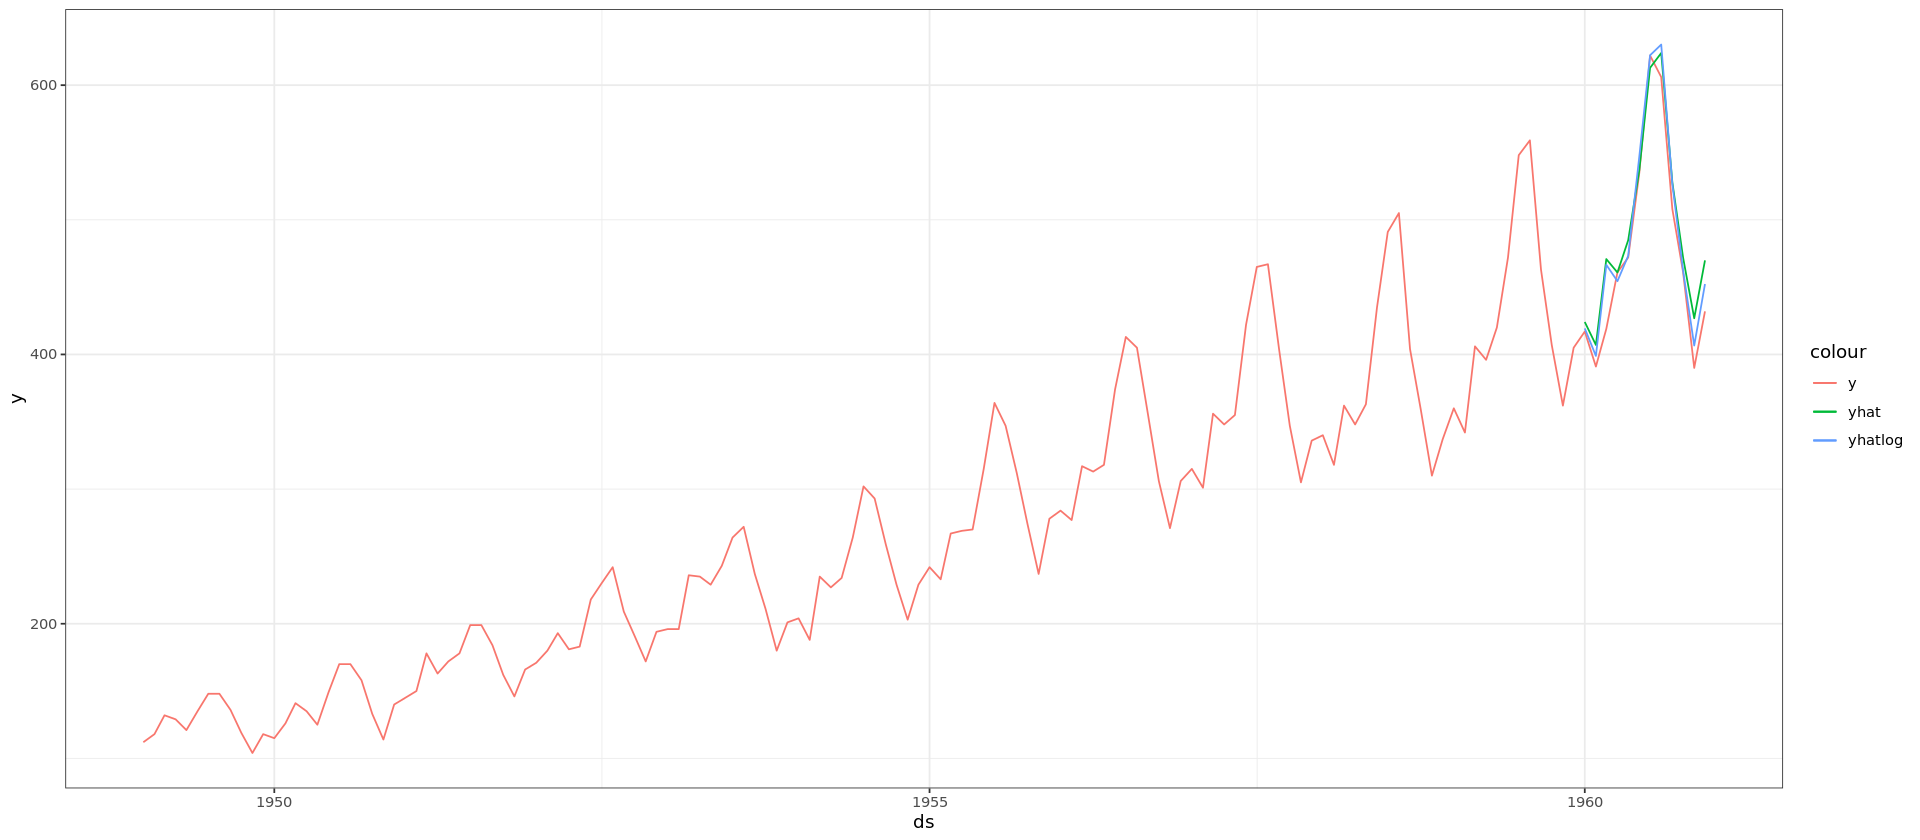

In [14]:
ggplot(dt_airpass_ar, aes(x=ds)) +
    geom_line(aes(y=y, color='y'), na.rm=TRUE) + 
    geom_line(aes(y=yhat, color='yhat'), na.rm=TRUE) + 
    geom_line(aes(y=yhatlog, color='yhatlog'), na.rm=TRUE) + theme_bw()

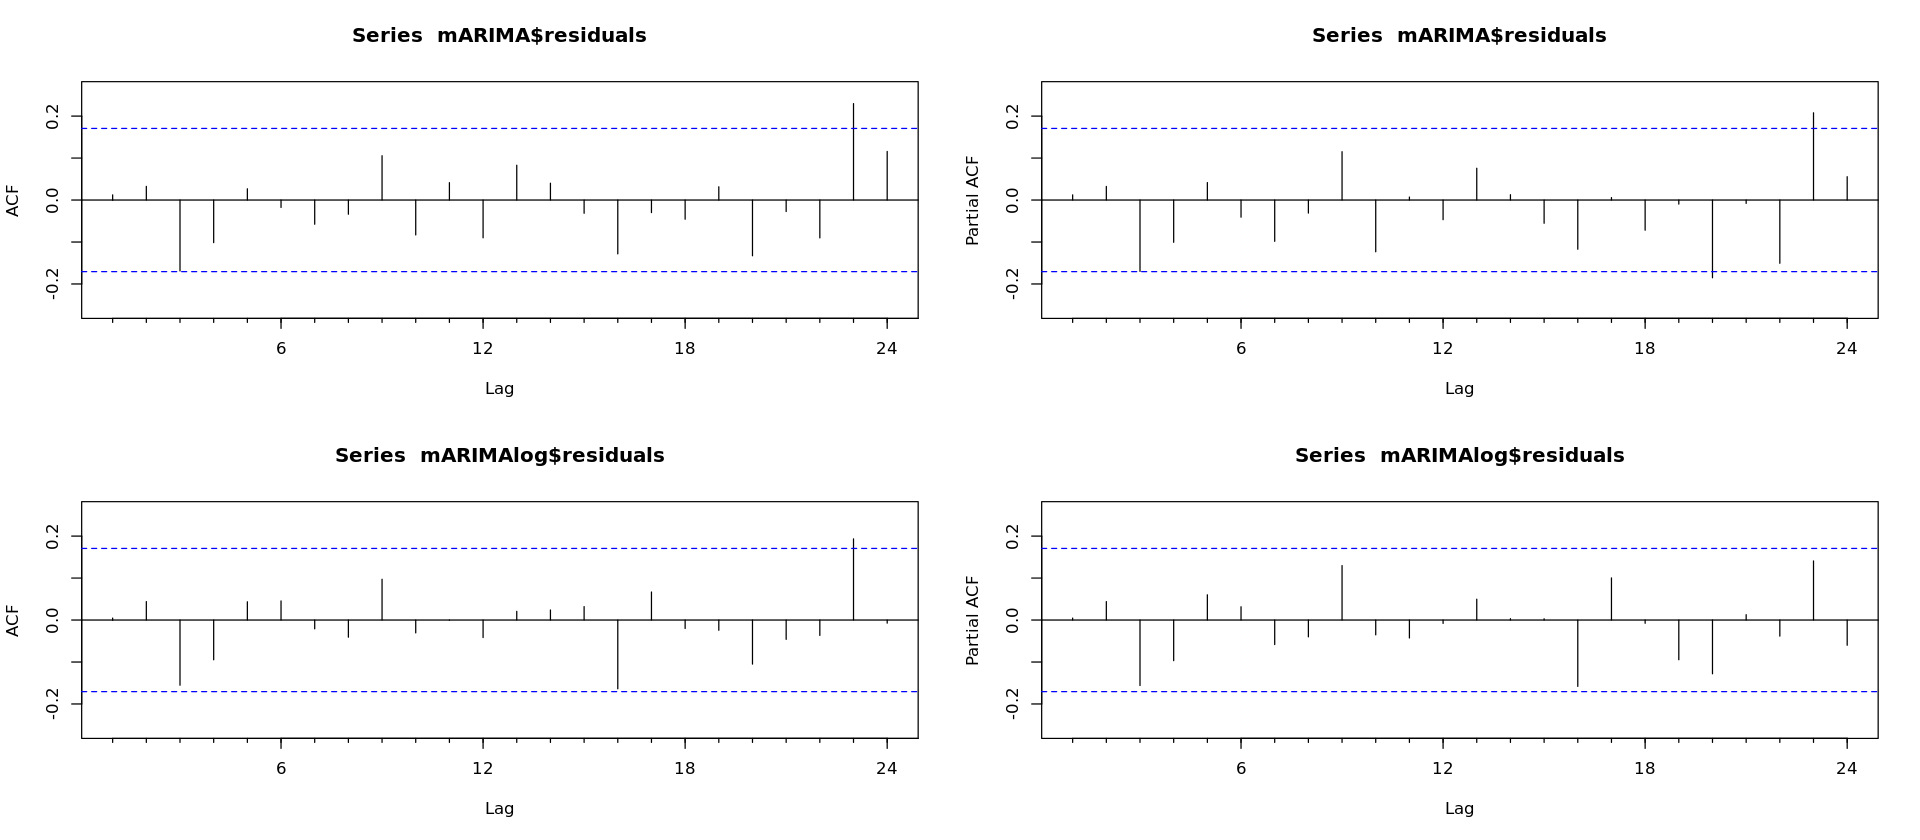

In [15]:
par(mfrow=c(2,2))
Acf(mARIMA$residuals)
Pacf(mARIMA$residuals)
Acf(mARIMAlog$residuals)
Pacf(mARIMAlog$residuals)

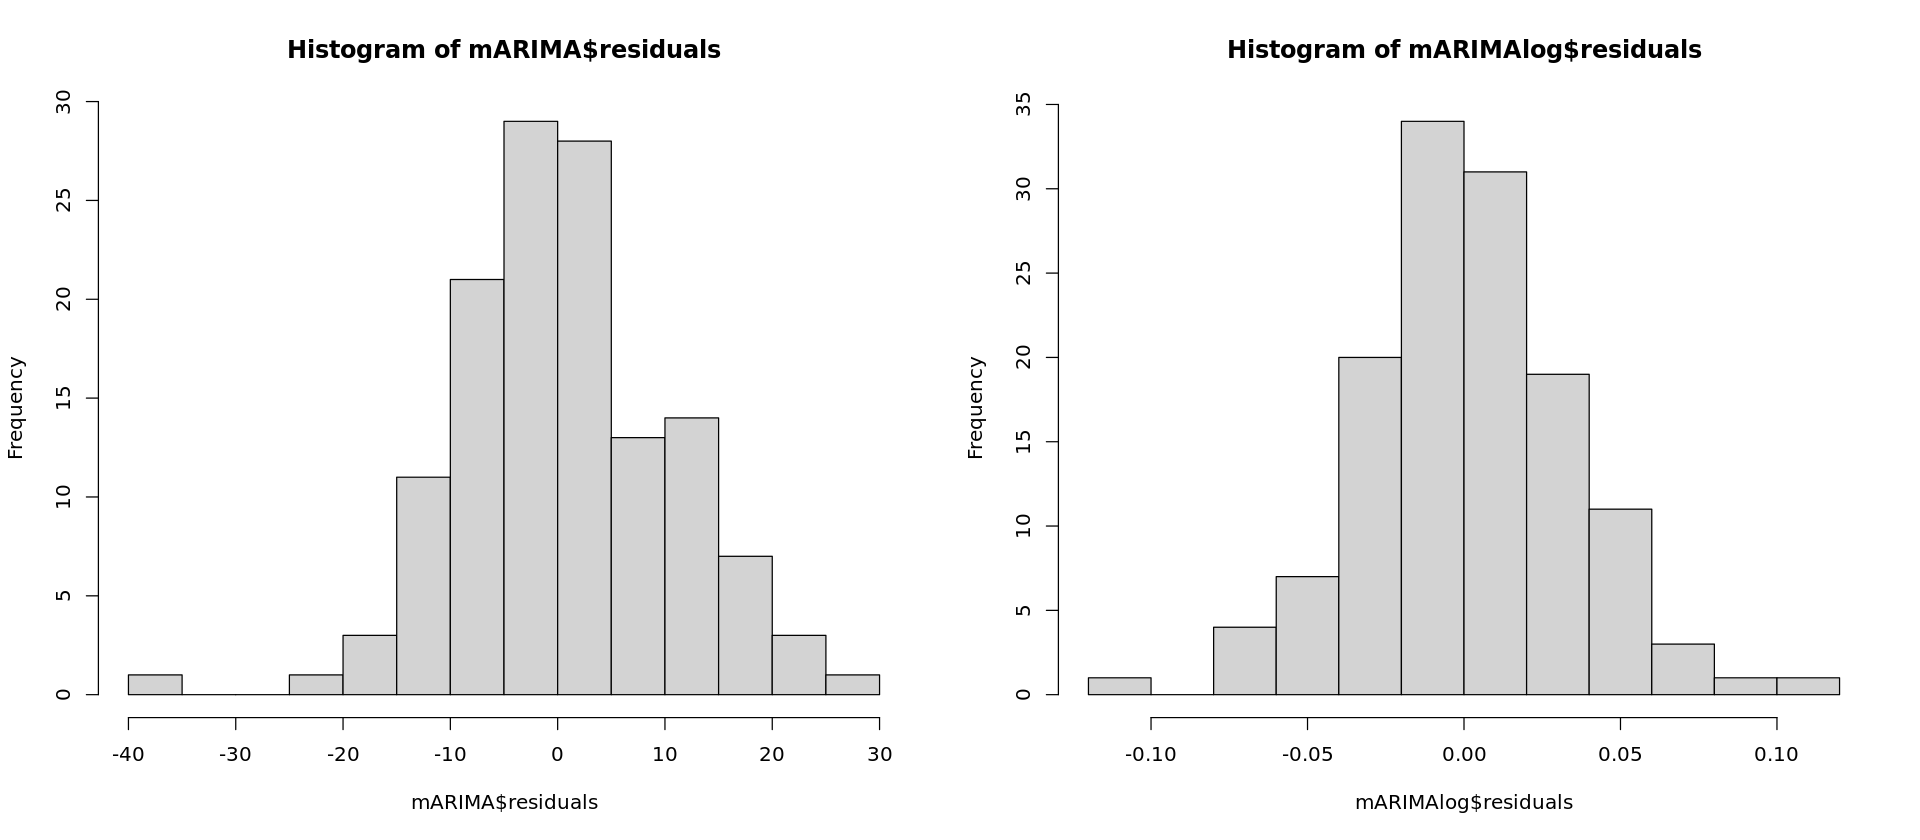

In [16]:
par(mfrow=c(1,2))
hist(mARIMA$residuals)
hist(mARIMAlog$residuals)

### Holt-Winters

The Holt-Winters seasonal method comprises of forecast equation and three smoothing equations — one for the level ℓ(t), one for the trend b(t), and one for the seasonal component s(t), with corresponding smoothing parameters α, β, and γ.  
We use m to denote the frequency of the seasonality, i.e., the number of seasons in a year. For example, for quarterly data m=4 and for monthly data m=12.

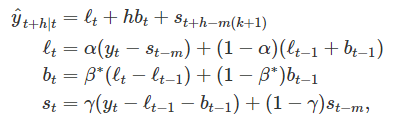

In [17]:
tsAir_trn <- head(AirPassengers,length(AirPassengers)-12)
tsAir_val <- tail(AirPassengers,12)
dt_airpass_hw <- data.table(ds=seq.Date(from=as.Date('1949-01-01'), to=as.Date('1960-12-01'), 'months'), 
                            y=as.numeric(AirPassengers))
dt_airpass_hw[,':='(yhat=as.numeric(NA),yhatlog=as.numeric(NA))]

mhw <- HoltWinters(tsAir_trn)
mhwlog <- HoltWinters(log(tsAir_trn))

dt_airpass_hw[ds>='1960-01-01'
              ,':='(yhat=as.numeric(predict(mhw,12)),
                    yhatlog=as.numeric(exp(predict(mhwlog,12))))]
mape_air_hw <- mape(dt_airpass_hw[ds>='1960-01-01']$y, dt_airpass_hw[ds>='1960-01-01']$yhat)
mape_air_hwlog <- mape(dt_airpass_hw[ds>='1960-01-01']$y, dt_airpass_hw[ds>='1960-01-01']$yhatlog)
cat(sprintf('Holt-Winters MAPE without log is %s\n',round(mape_air_hw,5)))
cat(sprintf('Holt-Winters MAPE with log is %s\n',round(mape_air_hwlog,5)))

Holt-Winters MAPE without log is 0.0252
Holt-Winters MAPE with log is 0.03629


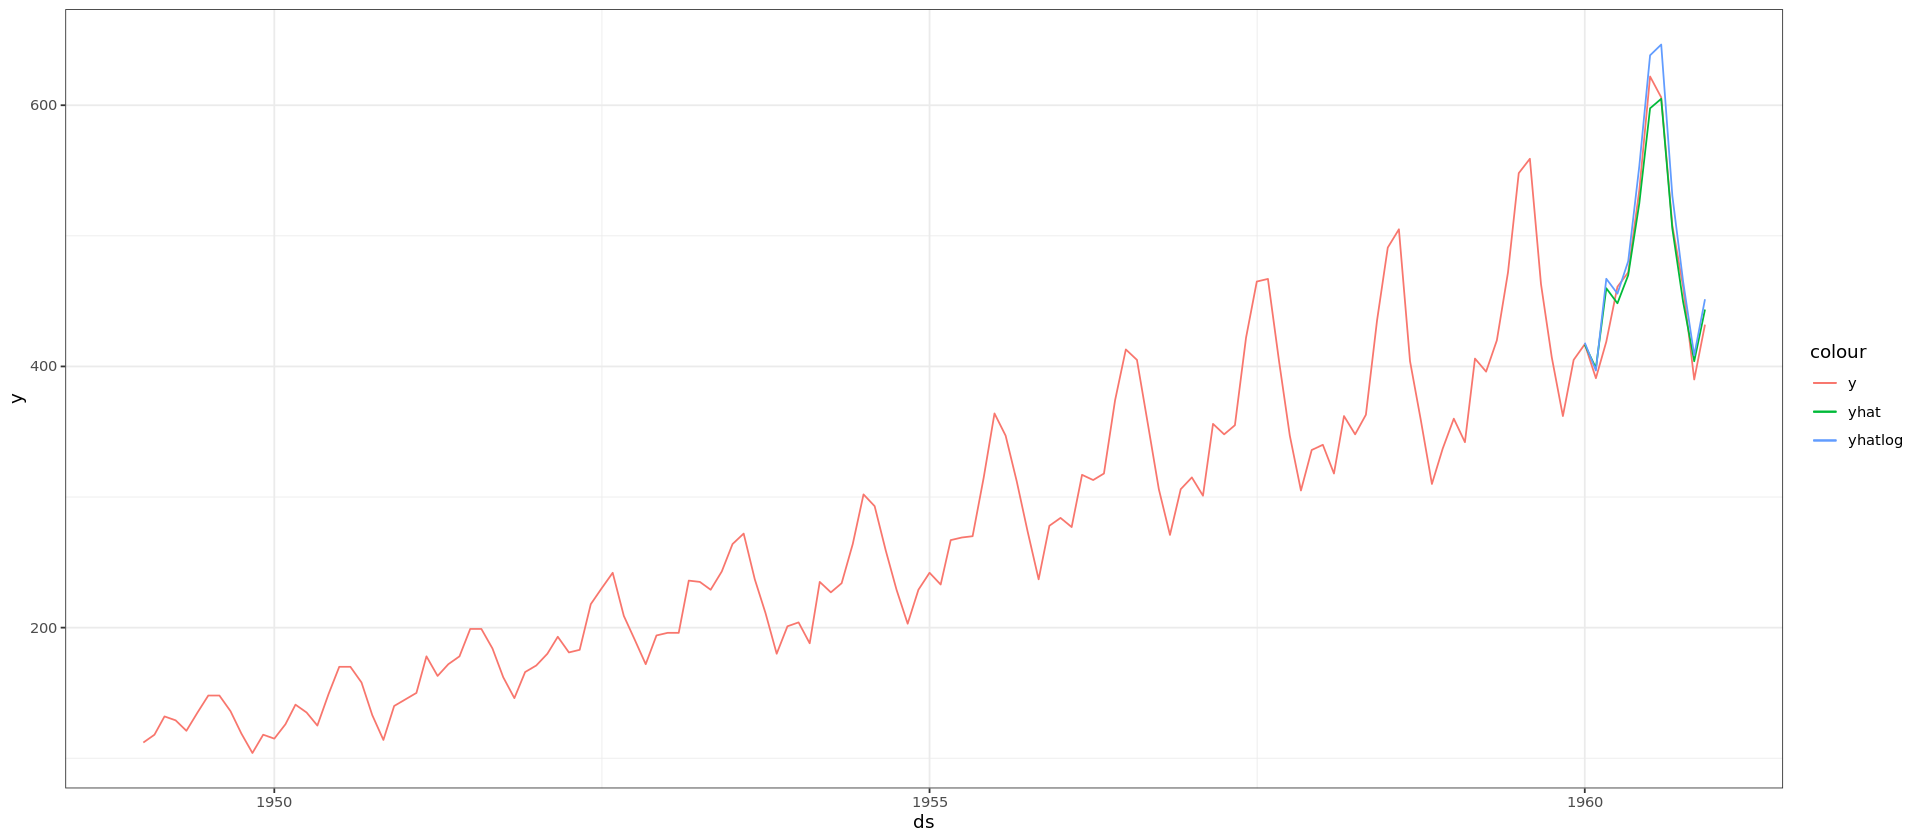

In [18]:
ggplot(dt_airpass_hw, aes(x=ds)) +
    geom_line(aes(y=y, color='y'), na.rm=TRUE) + 
    geom_line(aes(y=yhat, color='yhat'), na.rm=TRUE) + 
    geom_line(aes(y=yhatlog, color='yhatlog'), na.rm=TRUE) + theme_bw()

### Prophet

In [19]:
dt_airpass <- data.table(ds=seq.Date(from=as.Date('1949-01-01'), to=as.Date('1960-12-01'), 'months'), 
                         y=as.numeric(AirPassengers))
dt_airpass[,log_y:=log(dt_airpass$y)]

# Directly Forecasting without log
m <- prophet(dt_airpass[ds<'1960-01-01',.(ds,y=y)], weekly.seasonality= F,daily.seasonality=F, 
             seasonality.mode = 'multiplicative')
prop_fore <- as.data.table(predict(m, dt_airpass[,.(ds)]))
dt_airpass$yhat <- prop_fore$yhat
dt_airpass[,yhat:=ifelse(ds<'1960-01-01',NA,yhat)]

# Forecasting with log of y
m <- prophet(dt_airpass[ds<'1960-01-01',.(ds,y=log_y)], weekly.seasonality= F,daily.seasonality=F, 
             seasonality.mode = 'multiplicative')
prop_fore <- as.data.table(predict(m, dt_airpass[,.(ds)]))
dt_airpass$yhatlog <- prop_fore$yhat
dt_airpass[,yhatlog:=ifelse(ds<'1960-01-01',NA,exp(yhatlog))]
mape_air_prop <- mape(dt_airpass[ds>='1960-01-01']$y, dt_airpass[ds>='1960-01-01']$yhat)
mape_air_proplog <- mape(dt_airpass[ds>='1960-01-01']$y, dt_airpass[ds>='1960-01-01']$yhatlog)

cat(sprintf('Prophet MAPE without log is %s\n',round(mape_air_prop,5)))
cat(sprintf('Prophet MAPE with log is %s\n',round(mape_air_proplog,5)))

Prophet MAPE without log is 0.04419
Prophet MAPE with log is 0.04455


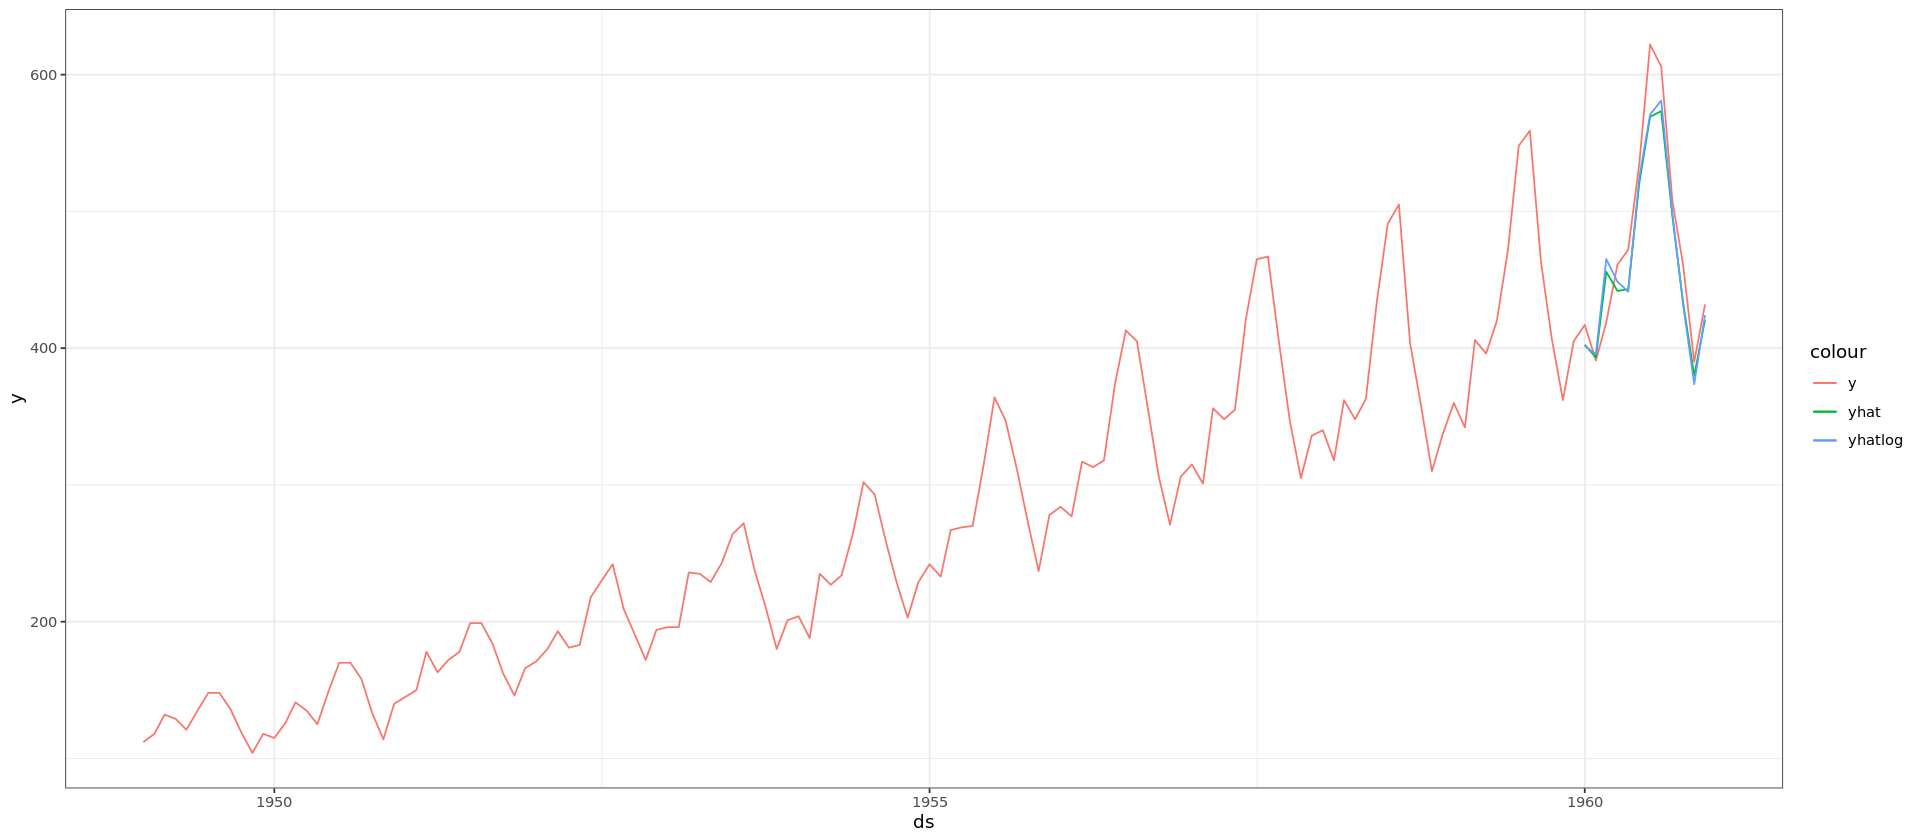

In [20]:
ggplot(dt_airpass, aes(x=ds)) +
    geom_line(aes(y=y, color='y'), na.rm=TRUE) + 
    geom_line(aes(y=yhat, color='yhat'), na.rm=TRUE) + 
    geom_line(aes(y=yhatlog, color='yhatlog'), na.rm=TRUE) + theme_bw()

## Additional EDA: Users can use this example for trial

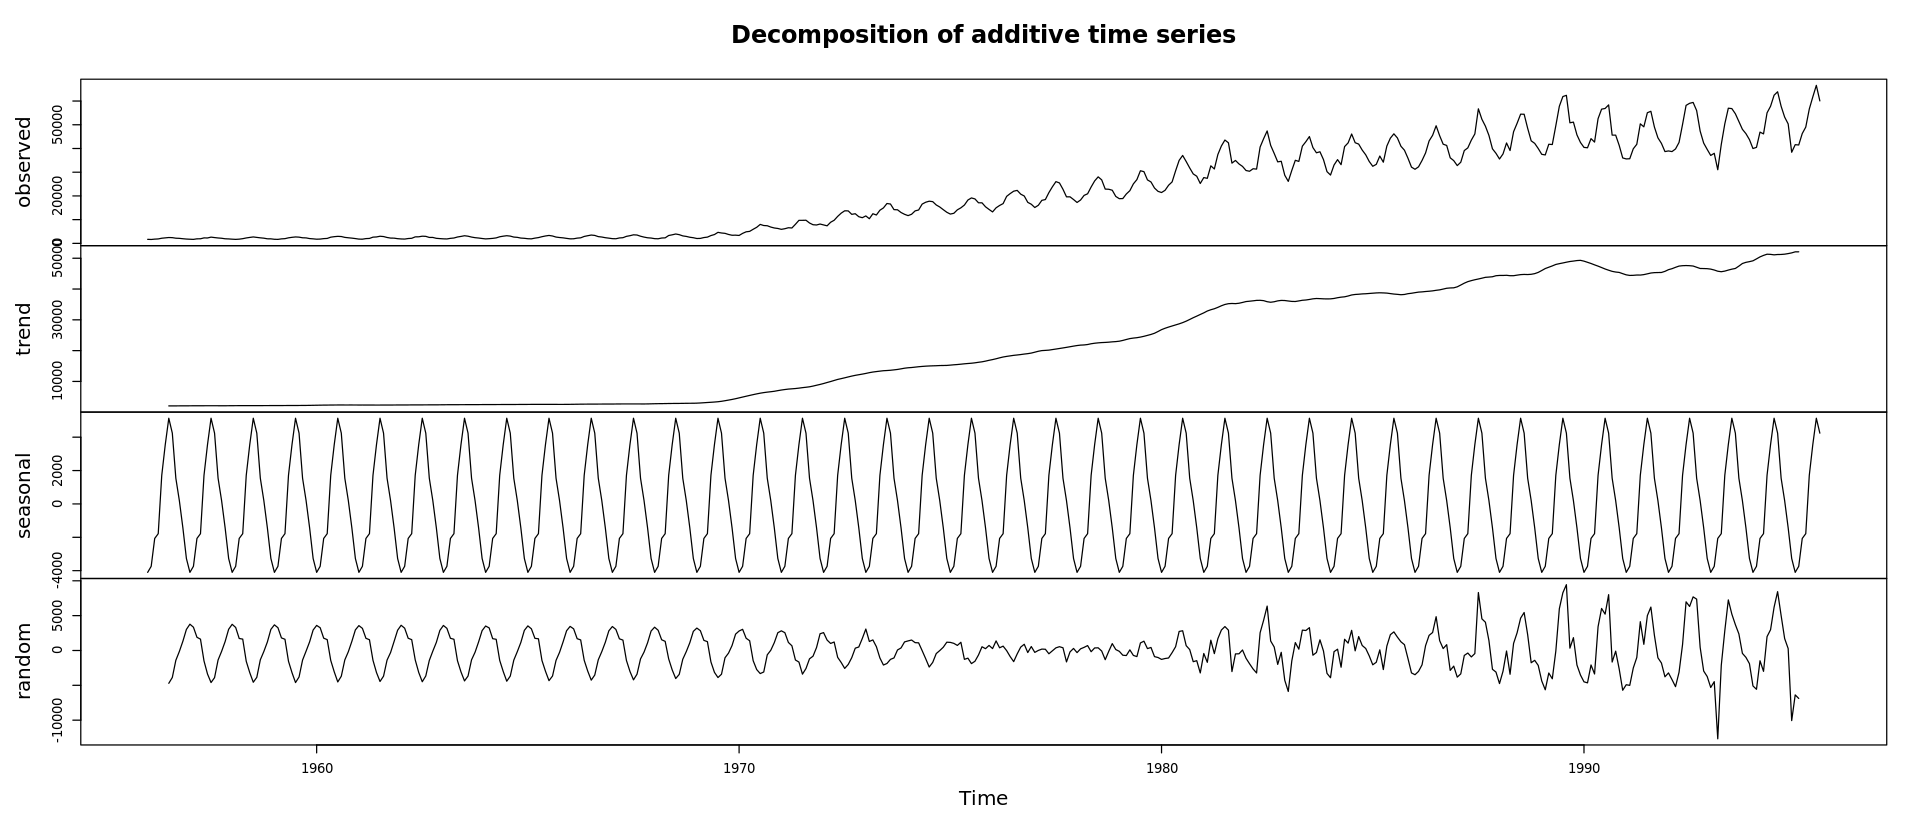

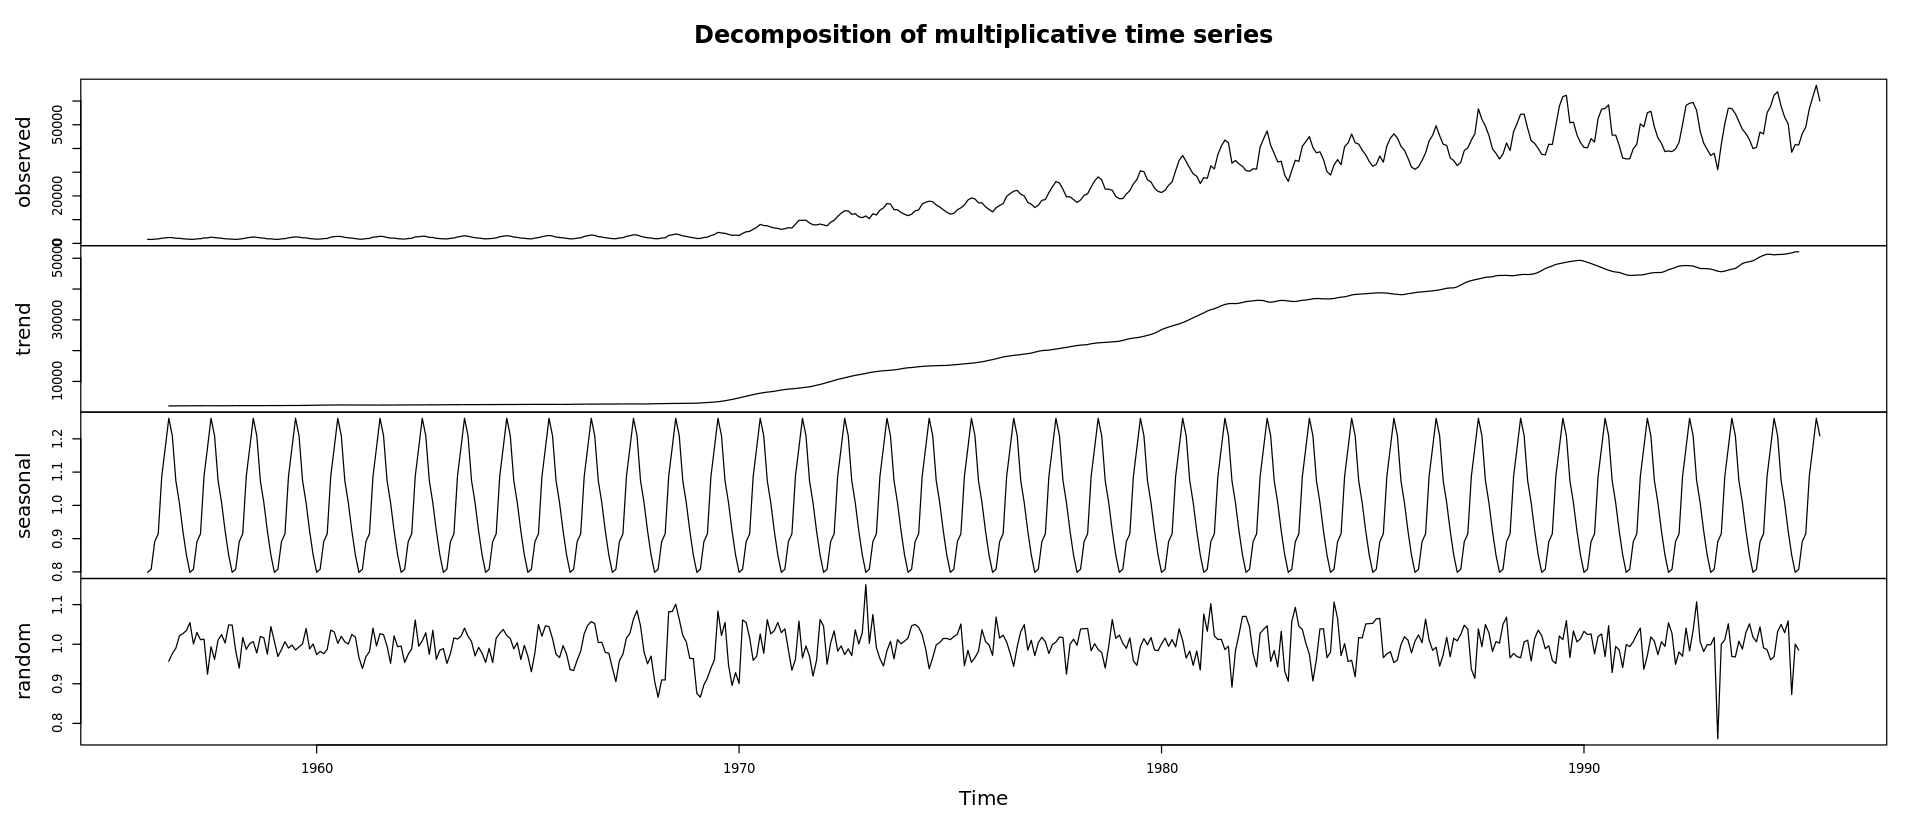

In [21]:
plot(decompose(gas,type='additive'))
plot(decompose(gas,type='multiplicative'))

## Important Links for reference

Time series with R: https://a-little-book-of-r-for-time-series.readthedocs.io/en/latest/src/timeseries.html  
Complete guide: https://otexts.com/fpp2/index.html